In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from pylab import rcParams
rcParams['figure.figsize'] = 25, 10
import numpy as np 
import dill as pickle
import os
import random
import datetime 
import sys 
import seaborn as sns
from einops import rearrange
import matplotlib as mpl
from matplotlib.patches import Rectangle
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.flasso.Replicate import Replicate
from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_cosines import get_cosines
from codes.plotting.supportrecovery import plot_watch3,plot_reg_path_ax_lambdasearch_customcolors_norm
from itertools import combinations

def get_names(subset):
    
    names = np.zeros(len(subset), dtype = object)
    for s in range(len(subset)):
        names[s] = r"$g_{{{}}}$".format(subset[s])
    return(names)

def get_color_subset(color_superset, superset, subset):
    
    colors_subset = np.zeros((len(subset),4 ))
    print(subset.shape,colors_subset.shape)
    for s in range(len(subset)):
        colors_subset[s] = color_superset[np.where(superset == subset[s])[0]] 
    return(colors_subset)
def get_detected_values(subset, supports):
    
    detected_values = np.zeros((subset.shape[0],subset.shape[0]))
    nreps = len(list(supports.keys()))
    for r in range(nreps):
        i1 = np.where(subset == int(supports[r][0]))[0]
        i2 = np.where(subset == int(supports[r][1]))[0]
        detected_values[i1,i2] += 1
        detected_values[i2,i1] += 1
    
    detected_values = np.asarray(np.where(detected_values > 0))
    return(detected_values)

def get_support_indices(sup_set, sup_sel):
    
    toplot = np.zeros((sup_set.shape[0],sup_set.shape[0]))
    for r in range(nreps):
        i1 = np.where(sup_set == sup_sel[r][0])[0]
        i2 = np.where(sup_set == sup_sel[r][1])[0]
        toplot[i1,i2] += 1
        toplot[i2,i1] += 1   
    return(toplot)

def get_cmap(subset):
    
    cmap = plt.get_cmap('rainbow',len(subset))
    colors_subset = np.zeros((len(subset),4))
    for s in range(len(subset)):
        colors_subset[s] = cmap(s)   
        
    return(colors_subset)

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import math
from matplotlib import rcParams
rcParams['figure.figsize'] = 25, 10
from collections import OrderedDict
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from sklearn.decomposition import TruncatedSVD
from shutil import copyfile
import scipy

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.flasso.Replicate import Replicate
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.TangentBundle import TangentBundle
from codes.geometer.ShapeSpace import ShapeSpace
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel
from codes.otherfunctions.get_grads import get_grads3
from codes.experimentclasses.RigidEthanolPCA3 import get_rigid_ethanol_data

n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
diffusion_time = 1. #embedding radius
dim = 2 #manifold dimension
dimnoise = 2 #manifold dimension (not in mflasso paper)
cores = 3 
nreps = 1
natoms = 9

#savename = 'malonaldehyde_021521'
#savefolder = 'malonaldehyde'
#loadfolder = 'malonaldehyde'
#loadname = 'malonaldehyde_021521'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

#folder = workingdirectory + '/Figures/malonaldehyde/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
#os.mkdir(folder)
experiment = AtomicRegression(natoms)
experiment.m = m
experiment.dim = dim
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.atoms3, experiment.da = experiment.get_atoms_3()
experiment.atoms4,experiment.p = get_all_atoms_4(natoms)

data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'
data_xyz_loaded = scipy.io.loadmat(data_wd + '/untracked_data/chemistry_data/malonaldehyde.mat')
angle_indices = np.load(data_wd + '/untracked_data/chemistry_data/malonaldehydeindices022119.npy')
experiment.positions =  data_xyz_loaded['R'][angle_indices]
filename_angles = data_wd + '/untracked_data/chemistry_data/malonaldehydeangles022119.npy'
data = np.arccos(np.reshape(np.load(filename_angles), (50000, experiment.da)))

experiment.M = RiemannianManifold(data, dim)#experiment.load_data(workingdirectory = data_wd)
experiment.svd = TruncatedSVD(n_components=50)
experiment.Mpca = RiemannianManifold(experiment.svd.fit_transform(experiment.M.data), dim)
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)


/Users/samsonkoelle/manifoldflasso_jmlr


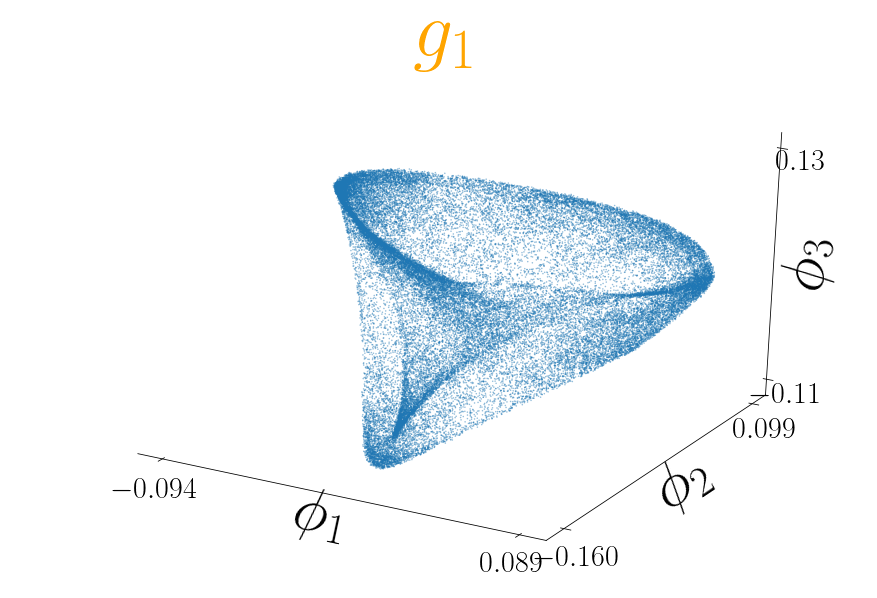

In [4]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z,  s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_groundtruth_g1')